In [70]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt


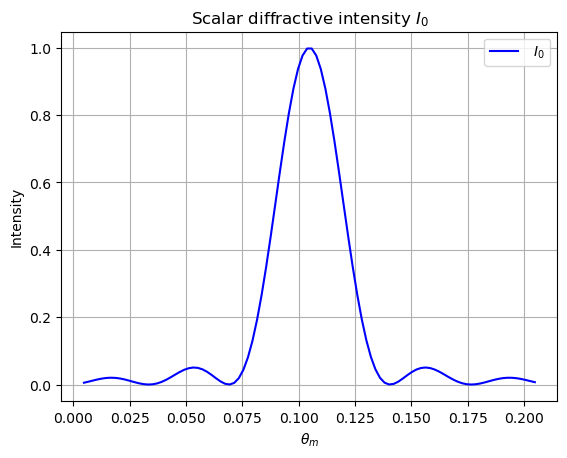

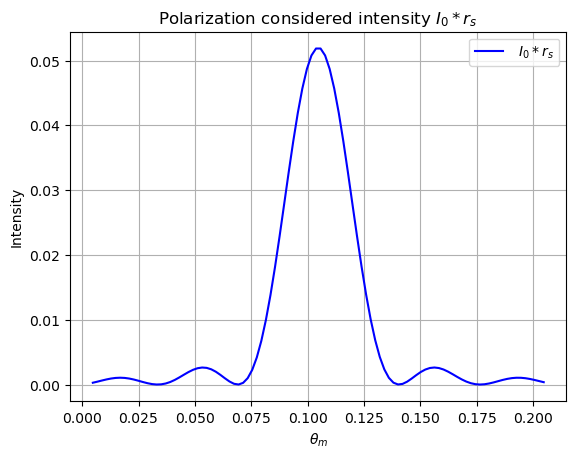

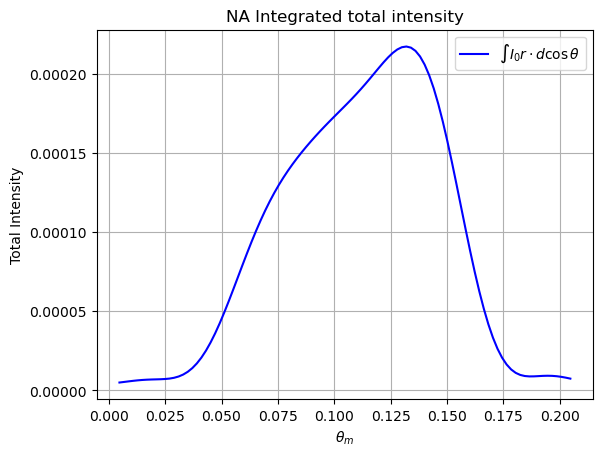

In [71]:
class MathFunctionsHandler:
    def __init__(self,wavelength,d,theta_i,aperture_angle,n1,n2,N):
        self.wavelength = wavelength
        self.d = d
        self.theta_i = theta_i
        self.aperture_angle = aperture_angle
        self.n1 = n1
        self.n2 = n2
        self.N = N
    
    def GenFuncDiffractive(self):
        wavelength = self.wavelength
        d = self.d
        N = self.N            
        def scalar_diffraction_intensity(theta_i,theta_m):
            """
            标量衍射理论的光强分布计算。
            
            参数:
            N: 光栅条纹数
            d: 光栅周期
            theta_m: 衍射角度（弧度）
            theta_i: 入射角度（弧度）
            wavelength: 光的波长
            
            返回:
            I: 衍射光强度
            """
            k = 2 * np.pi / wavelength  # 波数
            beta = k * d * (np.sin(theta_m) - np.sin(theta_i)) / (2 * np.pi)
            # 计算强度分布
            intensity = (np.sin(N * np.pi * beta) / (N * np.sin(np.pi * beta)))**2
            return intensity
    
        return scalar_diffraction_intensity

    def GenFuncReflective(self,polarization):        
        n1 = self.n1
        n2 = self.n2
        def fresnel_reflection(theta_i):
            """
            计算菲涅尔反射系数，支持 s-偏振和 p-偏振模式。
            
            参数:
            n1: 入射介质折射率
            n2: 光栅材料折射率
            theta_i: 入射角（弧度）
            polarization: 偏振模式 ('s' 或 'p')
            
            返回:
            r: 反射系数
            """
            sin_theta_i = np.sin(theta_i)
            cos_theta_i = np.cos(theta_i)
            
            # 计算 cos(theta_t) 使用斯涅尔定律
            sin_theta_t = n1 * sin_theta_i / n2
            cos_theta_t = np.sqrt(1 - sin_theta_t**2)
            
            if polarization == 's':
                # s-偏振光的反射系数
                r = (n1 * cos_theta_t - n2 * cos_theta_i) / (n1 * cos_theta_t + n2 * cos_theta_i)
            elif polarization == 'p':
                # p-偏振光的反射系数
                r = (n2 * cos_theta_t - n1 * cos_theta_i) / (n2 * cos_theta_t + n1 * cos_theta_i)
            else:
                raise ValueError("polarization must be 's' or 'p'")
            
            return np.abs(r)
        return fresnel_reflection
    
    def GenFuncInegrated(self,intensity_func,theta_i):
        aperture_angle = self.aperture_angle
        theta_i_0 = theta_i
        def I(theta_m):
            def integrand(theta_i):
                return intensity_func(theta_i,theta_m)*np.sin(theta_i)
            result, error = quad(integrand, theta_i_0-aperture_angle/2.,theta_i_0+aperture_angle/2.)
            return result
        return I
    
    # Get I with fixed theta_i
    def GenFuncFixed(self,I,theta_i):
        theta_i_0 = theta_i        
        def I_fixed(theta_m):
            return I(theta_i_0,theta_m)
        return I_fixed



def plot_func(f,xmin,xmax,Np,label='$f(x)$',title='Func plot',label_x='x',label_y='f(x)'):
    f_vectorized = np.vectorize(f)

    # 生成 x 轴数据
    x = np.linspace(xmin, xmax, Np)

    # 计算 y 值
    y = f_vectorized(x)

    # 绘制图像
    plt.plot(x, y, label=label, color='b')

    # 添加标题和轴标签
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)

    # 添加网格和图例
    plt.grid(True)
    plt.legend()

    # 显示图像
    plt.show()
    return x,y


d2r = 2.*np.pi/360
wavelength = 13.5
d = 38
theta_i = 6*d2r
aperture_angle = 0.1
n1 = 1.
n2 = 0.9
N = 10
generator = MathFunctionsHandler(wavelength,d,theta_i,aperture_angle,n1,n2,N)

# scalar diffractive
I0 = generator.GenFuncDiffractive()
I0_theta_m = generator.GenFuncFixed(I0,theta_i)

plot_func(I0_theta_m,theta_i-0.1,theta_i+0.1,100,' $I_0$','Scalar diffractive intensity $I_0$','$\\theta_m$','Intensity')

# polarization considered
reflective_ratio = generator.GenFuncReflective(polarization='s')
def WrapI(I0,reflective_ratio,theta_i):
    def I1(theta_m):
        return I0(theta_i,theta_m)*reflective_ratio(theta_i)
    return I1

I1 = WrapI(I0,reflective_ratio,theta_i)
plot_func(I1,theta_i-0.1,theta_i+0.1,100,' $I_0*r_s$','Polarization considered intensity $I_0*r_s$','$\\theta_m$','Intensity')

# NA considered
def WrapI2(I0,reflective_ratio):
    def I(theta_i,theta_m):
        return I0(theta_i,theta_m)*reflective_ratio(theta_i)
    return generator.GenFuncInegrated(I,theta_i)
I2 = WrapI2(I0,reflective_ratio)
x,y = plot_func(I2,theta_i-0.1,theta_i+0.1,100,r'$\int I_0r\cdot d\cos\theta$','NA Integrated total intensity','$\\theta_m$','Total Intensity')

        

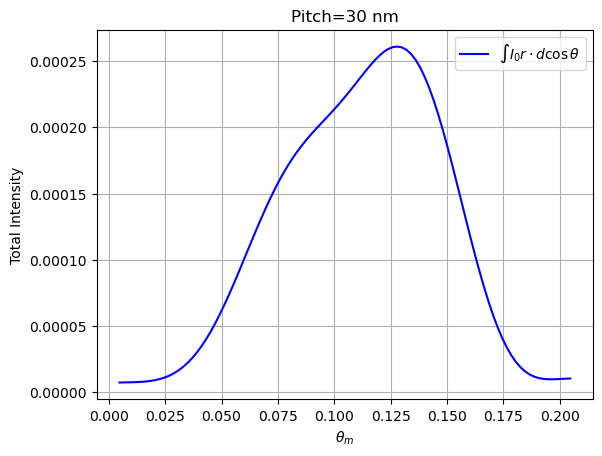

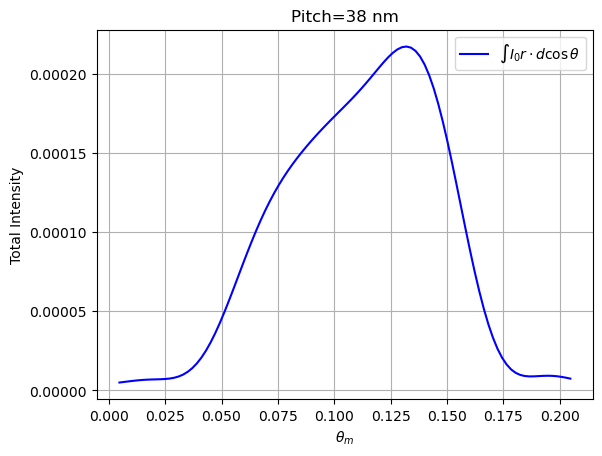

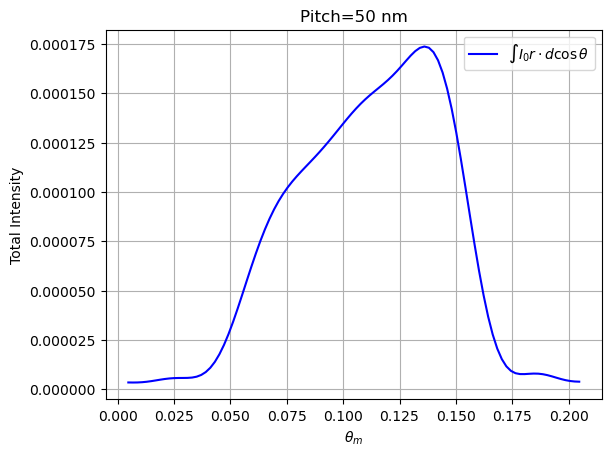

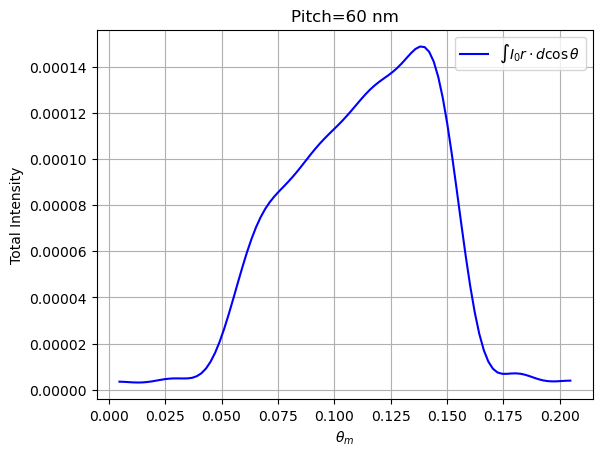

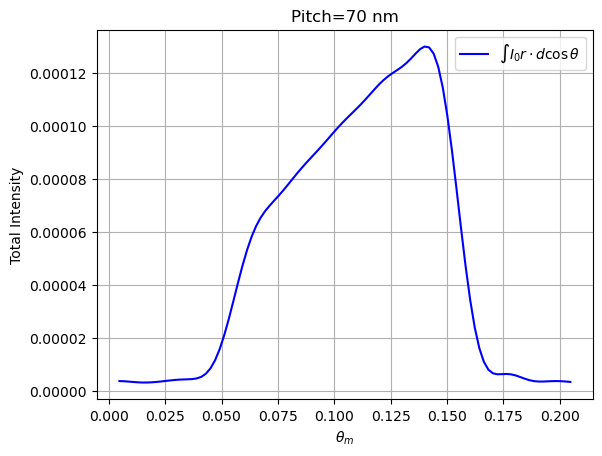

In [72]:
def WrapI2(I0,reflective_ratio):
        def I(theta_i,theta_m):
            return I0(theta_i,theta_m)*reflective_ratio(theta_i)
        return generator.GenFuncInegrated(I,theta_i)

# scan on D
vals = {}
for d in [30,38,50,60,70]:
    generator = MathFunctionsHandler(wavelength,d,theta_i,aperture_angle,n1,n2,N)

    # scalar diffractive
    I0 = generator.GenFuncDiffractive()
    # relective ratio
    reflective_ratio = generator.GenFuncReflective(polarization='s')
    # NA    
    I2 = WrapI2(I0,reflective_ratio)
    x,y = plot_func(I2,theta_i-0.1,theta_i+0.1,100,r'$\int I_0r\cdot d\cos\theta$','Pitch=%d nm'%(d),'$\\theta_m$','Total Intensity')
    vals[d] = [x,y]

            

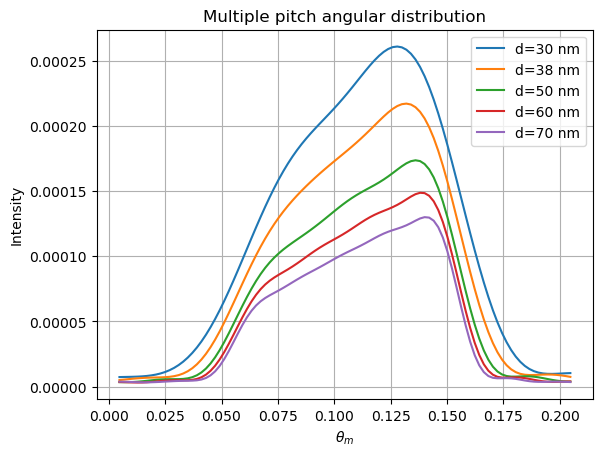

In [73]:
# 示例 data 字典
data = vals

# 绘制每一条曲线
for name, (x, y) in data.items():
    plt.plot(x, y, label='d=%02d nm'%(name))  # 每条曲线使用 name 作为 label

# 添加标题和轴标签
plt.title('Multiple pitch angular distribution')
plt.xlabel('$\\theta_m$')
plt.ylabel('Intensity')

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图像
plt.show()

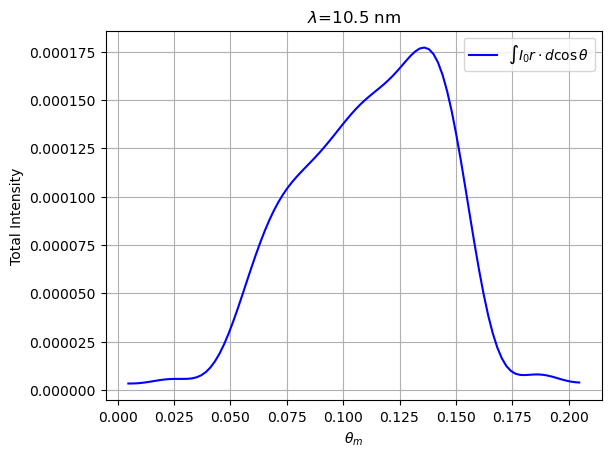

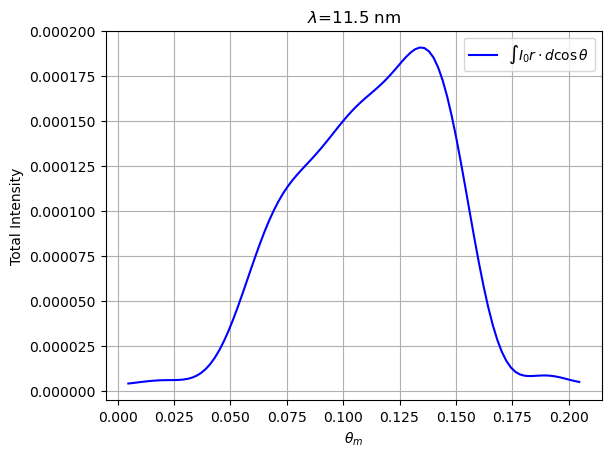

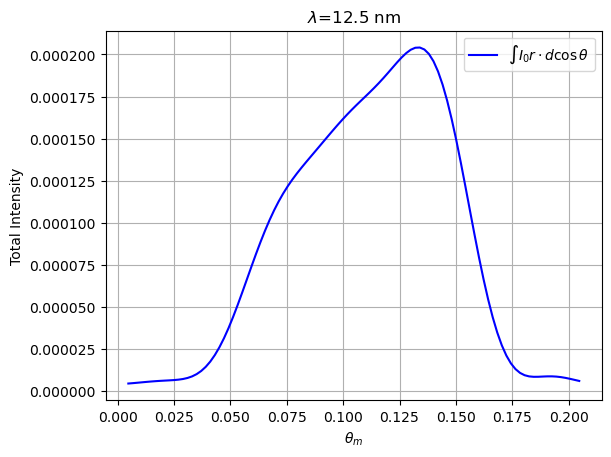

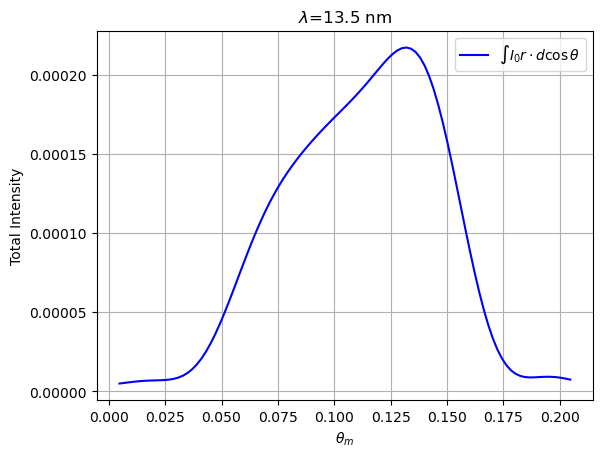

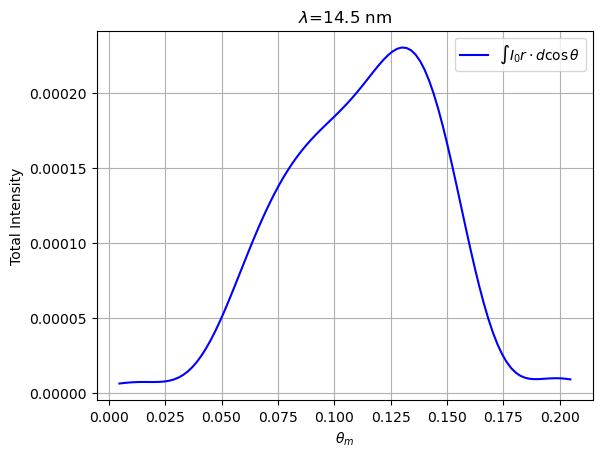

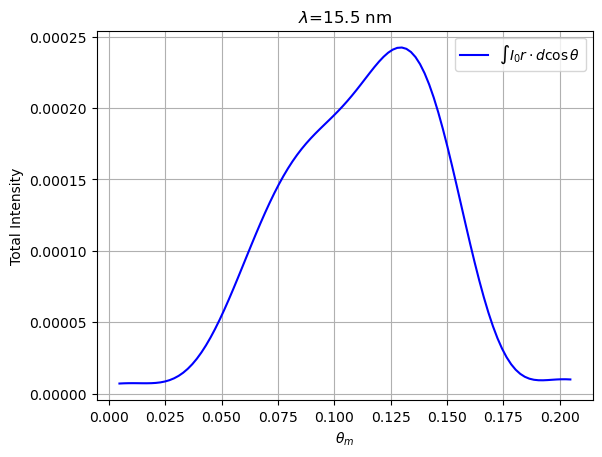

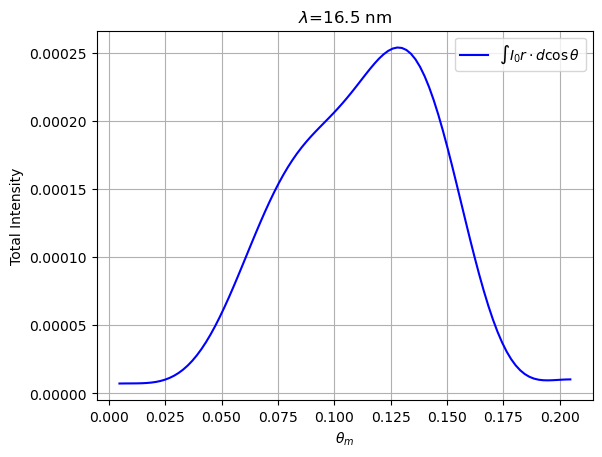

In [74]:


# scan on lambda
vals_lambda = {}
d = 38
for k in range(7):
    wavelength = 10.5+k

    generator = MathFunctionsHandler(wavelength,d,theta_i,aperture_angle,n1,n2,N)

    # scalar diffractive
    I0 = generator.GenFuncDiffractive()
    # relective ratio
    reflective_ratio = generator.GenFuncReflective(polarization='s')
    # NA    
    I2 = WrapI2(I0,reflective_ratio)
    x,y = plot_func(I2,theta_i-0.1,theta_i+0.1,100,r'$\int I_0r\cdot d\cos\theta$',r'$\lambda$=%.1f nm'%(wavelength),'$\\theta_m$','Total Intensity')
    vals_lambda[wavelength] = [x,y]



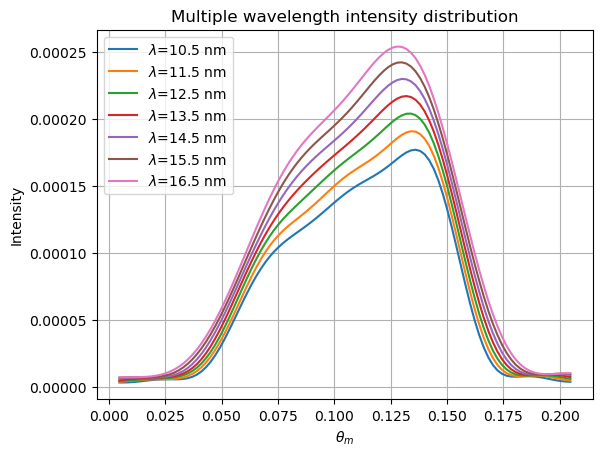

In [75]:
# 示例 data 字典
data = vals_lambda

# 绘制每一条曲线
for name, (x, y) in data.items():
    plt.plot(x, y, label=r'$\lambda$=%.1f nm'%(name))  # 每条曲线使用 name 作为 label

# 添加标题和轴标签
plt.title('Multiple wavelength intensity distribution')
plt.xlabel('$\\theta_m$')
plt.ylabel('Intensity')

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图像
plt.show()

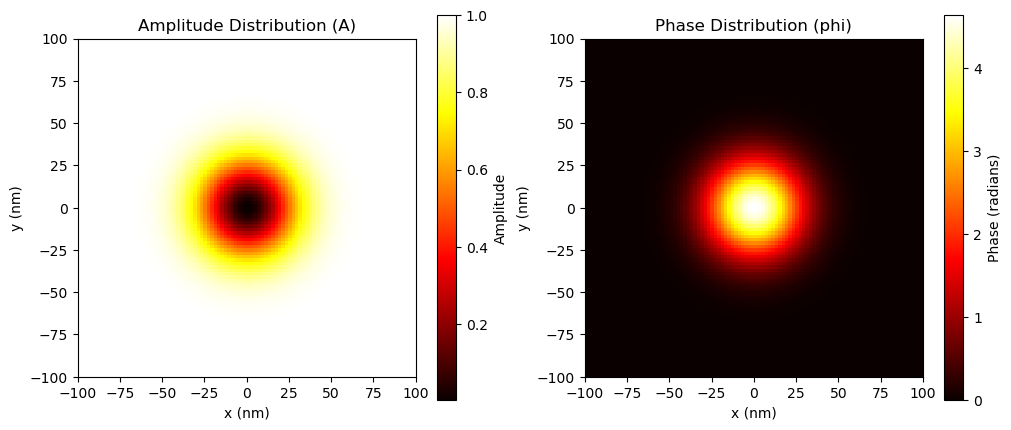

4.642354690110345


In [76]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gaussian_defect(h, sigma, alpha, lambda_euv=13.5, grid_size=100, plane_size=100):
    # grid_size 表示生成的矩阵大小, plane_size 表示样品平面尺寸 (100nm x 100nm)
    x = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    y = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    X, Y = np.meshgrid(x, y)

    # 定义高斯型缺陷，中心位置为(0,0)
    Z = h * np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    # 计算振幅 A 和相位 φ
    A = 1 + alpha * Z  # 振幅：假设无缺陷的振幅为1
    phi = (2 * np.pi * Z) / lambda_euv  # 相位：根据波长和高度计算

    # 计算光场复数分布：E = A * exp(i * φ)
    E = A * np.exp(1j * phi)

    return E, A, phi

# 设置参数
h = 10  # 缺陷的最大高度 (nm)
sigma = 10  # 高斯分布的标准差 (nm)
alpha = -0.1  # 反射率差异因子
lambda_euv = 13.5  # EUV波长 (nm)

# 生成光场矩阵
E, A, phi = generate_gaussian_defect(h, sigma, alpha, lambda_euv)
E_real = np.real(E)
A_matrix = np.abs(A)
phi_matrix = phi
# 可视化振幅和相位
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Amplitude Distribution (A)')
plt.imshow(np.abs(A), cmap='hot', extent=[-100, 100, -100, 100])
plt.colorbar(label='Amplitude')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')

plt.subplot(1, 2, 2)
plt.title('Phase Distribution (phi)')
plt.imshow(phi_matrix, cmap='hot', extent=[-100, 100, -100, 100])
plt.colorbar(label='Phase (radians)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')

plt.show()

# 返回E的实部、振幅和相位矩阵

print(max(phi[50]))

当你获得凹凸样品一系列离焦成像模拟图片时，分析这些图像中的梯度变化可以帮助你区分凹凸缺陷。这里的基本思想是：凸起和凹陷的样品会在不同的焦平面上呈现出不同的光强分布和梯度特性，这种变化可以通过图像的梯度来定量描述。

分析思路：

	1.	图像梯度计算：
	•	使用图像的空间梯度（例如 Sobel 算子）来计算每张图像中的边缘和强度变化。凸起和凹陷的光场会在不同的离焦平面上产生不同的梯度特征。
	2.	梯度变化随焦点的演化：
	•	凸起和凹陷的样品在焦点不同位置处的图像梯度变化表现为：
	•	凸起（protrusion）：在靠近焦点前的图像中（欠焦），梯度会更为强烈，因为凸起会使光束集中，形成较高对比度的图像。
	•	凹陷（depression）：在焦点后面（超焦）处，梯度较大，因为凹陷导致光程差异和散射，图像对比度增加。
	3.	梯度变化的定量分析：
	•	通过计算每张离焦图像的平均梯度强度，绘制梯度强度随焦平面移动的变化曲线。对于凸起和凹陷，曲线的峰值位置和变化趋势会有所不同。你可以通过这种梯度变化趋势区分凹凸缺陷。

具体步骤：

1. 计算图像梯度：

使用 Sobel 算子计算每张图像的梯度，得到图像的局部变化率。

2. 分析结果：

	•	凸起缺陷：在焦点靠前时（负离焦），梯度曲线会有一个峰值，表示凸起导致的光场聚焦。在焦点移动到后方时，梯度会减小。
	•	凹陷缺陷：相反，在焦点靠后时（正离焦），梯度曲线会有一个峰值，表示凹陷导致的光场发散和相位延迟。

预期结果：

通过这种分析方法，你可以预期到以下现象：

	1.	凸起缺陷：
	•	在欠焦时，凸起的光场变化会更剧烈，图像中的边缘对比更强，因此梯度值更高。在焦点前的位置，凸起区域会导致光线汇聚，产生较强的高对比度区域，梯度的峰值会出现在负的焦点位置。
	2.	凹陷缺陷：
	•	在超焦时，凹陷的光场变化会更明显，因为凹陷导致光场在焦点后进一步发散，形成更明显的梯度变化。梯度的峰值会出现在正的焦点位置，表明光线在凹陷区域的散射和相位延迟增强了梯度特性。

结论：

通过焦点扫描分析凹凸缺陷时，梯度变化曲线可以帮助你判断缺陷是凸起还是凹陷。通常，凸起缺陷的梯度峰值会在焦点靠前时出现，而凹陷缺陷的梯度峰值会在焦点靠后时出现。

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def calculate_image_gradient(image):
#     # 使用 Sobel 算子计算 x 和 y 方向的梯度
#     grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
#     grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
#     # 计算梯度幅值
#     gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
#     return gradient_magnitude

# def plot_gradients_vs_focus(images, focus_positions):
#     # 计算每张图像的平均梯度强度
#     gradients = []
#     for image in images:
#         grad = calculate_image_gradient(image)
#         avg_gradient = np.mean(grad)
#         gradients.append(avg_gradient)
    
#     # 绘制梯度随焦点位置变化的曲线
#     plt.plot(focus_positions, gradients, marker='o')
#     plt.title('Gradient Magnitude vs Focus Position')
#     plt.xlabel('Focus Position (z)')
#     plt.ylabel('Average Gradient Magnitude')
#     plt.show()

# # 模拟的多张离焦成像图片
# focus_positions = np.linspace(-10, 10, num=21)  # 假设从 -10 到 +10 的焦点位置
# images = [...]  # 你的一系列离焦图像 (2D numpy 数组)

# # 绘制梯度随焦点位置变化的曲线
# plot_gradients_vs_focus(images, focus_positions)

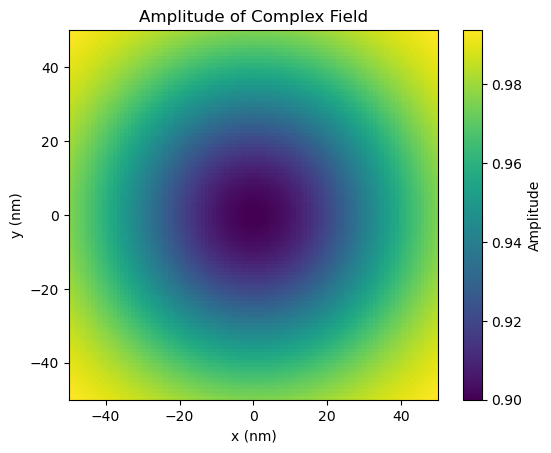

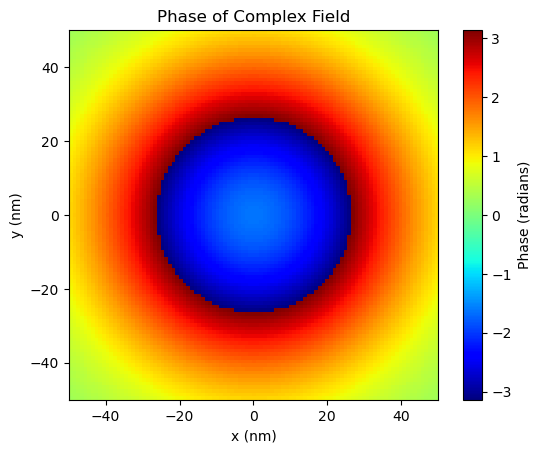

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def generate_complex_field(h, sigma, a0, alpha, lambda_wave, size=101, plane_size=100):
    # 创建网格坐标
    x = np.linspace(-plane_size / 2, plane_size / 2, size)
    y = np.linspace(-plane_size / 2, plane_size / 2, size)
    X, Y = np.meshgrid(x, y)
    
    # 计算高斯表面高度分布
    Z = h * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # 振幅部分，反射率随着高度降低：振幅 = a0 - Z * alpha
    A = a0 - alpha * Z  # 假设 alpha*h 给出反射率降低
    
    # 相位变化，取决于表面高度 Z 引起的光程差
    phase = (2 * np.pi * Z) / lambda_wave
    
    # 计算复数光场： E(x, y) = A(x, y) * exp(i * phase(x, y))
    E = A * np.exp(1j * phase)
    return E

# 示例参数
h = 10  # 高斯分布最大高度 10 nm
sigma = 30  # 高斯分布的宽度 30 nm
a0 = 1.0  # 平面部分的光场振幅
alpha = 0.01  # 反射率降低比例系数
lambda_wave = 13.5  # 光的波长，假设 550 nm
size = 101  # 输出矩阵的大小
plane_size = 100  # 物面为100 nm x 100 nm

# 生成光场复数分布
E_field = generate_complex_field(h, sigma, a0, alpha, lambda_wave, size, plane_size)

# 可视化复数光场的强度分布
plt.imshow(np.abs(E_field), extent=[-plane_size/2, plane_size/2, -plane_size/2, plane_size/2])
plt.title('Amplitude of Complex Field')
plt.colorbar(label='Amplitude')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

# 可视化相位分布
plt.imshow(np.angle(E_field), extent=[-plane_size/2, plane_size/2, -plane_size/2, plane_size/2], cmap='jet')
plt.title('Phase of Complex Field')
plt.colorbar(label='Phase (radians)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

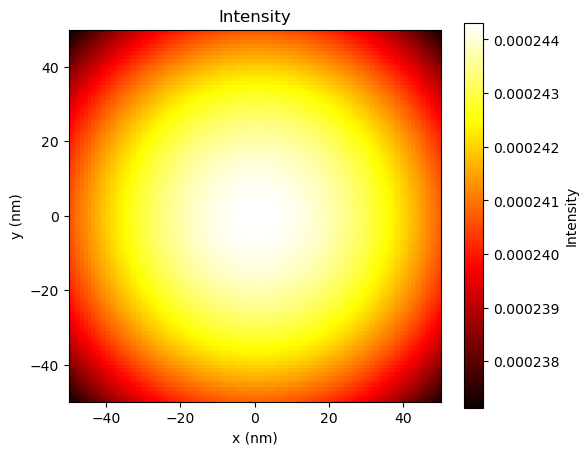

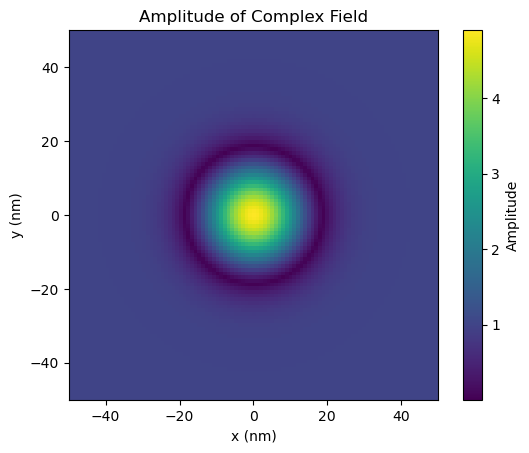

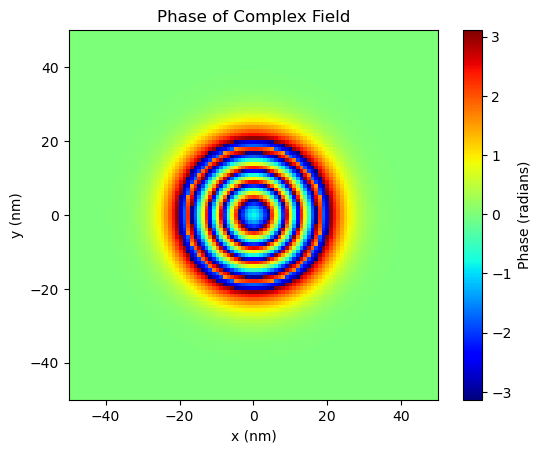

In [79]:
import numpy as np

# 已知参数（示例值）
import numpy as np
import matplotlib.pyplot as plt

# 已知参数（所有长度单位均为纳米）
lambda_wave = 13.5  # 波长，单位：nm（EUV波长）
NA_min = 0. # 最小数值孔径
NA_max = 0.01 # 最大数值孔径
pad_width = 1000  # 扩充宽度（像素数量）
M = 1  # 放大倍率

# 生成物面光场复振幅
def generate_complex_field(h, sigma, a0, alpha, lambda_wave, size=101, plane_size=100):
    # 创建网格坐标
    x = np.linspace(-plane_size / 2, plane_size / 2, size)
    y = np.linspace(-plane_size / 2, plane_size / 2, size)
    X, Y = np.meshgrid(x, y)
    
    # 计算高斯表面高度分布
    Z = h * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # 振幅部分，反射率随着高度降低：振幅 = a0 - Z * alpha
    A = a0 - alpha * Z
    
    # 相位变化，取决于表面高度 Z 引起的光程差
    phase = (2 * np.pi * Z) / lambda_wave
    
    # 计算复数光场： E(x, y) = A(x, y) * exp(i * phase(x, y))
    E = A * np.exp(1j * phase)
    
    return E

# 设置物面光场参数
h = 59  # 缺陷的最大高度，单位：nm
sigma = 10  # 高斯分布的标准差，单位：nm
a0 = 1  # 平面部分的光场振幅
alpha = 0.1  # 反射率降低比例系数
size = 101  # 矩阵大小
plane_size = 100  # 物面尺寸，单位：nm

# 生成物面光场
E_obj = generate_complex_field(h, sigma, a0, alpha, lambda_wave, size, plane_size)

# 第一步：扩充物方光场分布的矩阵
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)

# 获取扩充后的矩阵尺寸
N = E_obj_padded.shape[0]

# 计算物面采样间隔
dx = plane_size / size  # 物面采样间隔，单位：nm

# 第二步：进行傅立叶变换
# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx)  # 频率，单位：cycles/nm
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)

# 计算空间频率的幅值
f = np.sqrt(fx**2 + fy**2)

# 计算数值孔径 NA = f * λ
NA = f * lambda_wave

# 第三步：计算光瞳函数
# NA 限制部分
pupil_NA = np.logical_and(NA >= NA_min, NA <= NA_max).astype(float)

# 将直角坐标转换为极坐标
rho = NA / NA_max  # 归一化半径
phi = np.arctan2(fy, fx)

# 初始化波像差函数 W
W = np.zeros_like(rho)

# 定义 Zernike 多项式函数（需要实际实现）
def zern(j, rho, phi):
    # 这里需要实现实际的 Zernike 多项式计算
    # 为简化，暂时返回零矩阵
    return np.zeros_like(rho)

# 示例 Zernike 系数（长度为37的数组）
zern_coeff = np.zeros(37)  # 假设无波像差

# 计算波像差部分
for j in range(len(zern_coeff)):
    W += zern_coeff[j] * zern(j + 1, rho, phi)  # Zernike 多项式编号从 1 开始

# 计算光瞳函数，包括 NA 限制和波像差
pupil_function = pupil_NA * np.exp(1j * 2 * np.pi * W / lambda_wave)

# 第四步：将光瞳函数作用在傅立叶变换后的矩阵上
# 对扩充后的物面光场进行傅立叶变换
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用光瞳函数
E_image_fft = E_obj_fft * pupil_function

# 第五步：进行傅立叶逆变换得到像面光场分布
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光场强度
I_image = np.abs(E_image)**2

# 计算像面坐标
lambda_eff = lambda_wave / M  # 考虑放大倍率后的有效波长
dx_image = 1 / (N * (1 / (dx * N))) * lambda_eff  # 像面采样间隔，单位：nm
x_image = np.linspace(-N/2, N/2-1, N) * dx_image
y_image = x_image

# 显示结果
plt.figure(figsize=(6, 5))
plt.imshow(I_image[1000:1100,1000:1100], extent=[-50,50,-50,50], cmap='hot')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Intensity')
plt.colorbar(label='Intensity')
plt.show()


# 可视化复数光场的强度分布
plt.imshow(np.abs(E_obj), extent=[-plane_size/2, plane_size/2, -plane_size/2, plane_size/2])
plt.title('Amplitude of Complex Field')
plt.colorbar(label='Amplitude')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

# 可视化相位分布
plt.imshow(np.angle(E_obj), extent=[-plane_size/2, plane_size/2, -plane_size/2, plane_size/2], cmap='jet')
plt.title('Phase of Complex Field')
plt.colorbar(label='Phase (radians)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20809 (\N{CJK UNIFIED IDEOGRAPH-5149}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWar

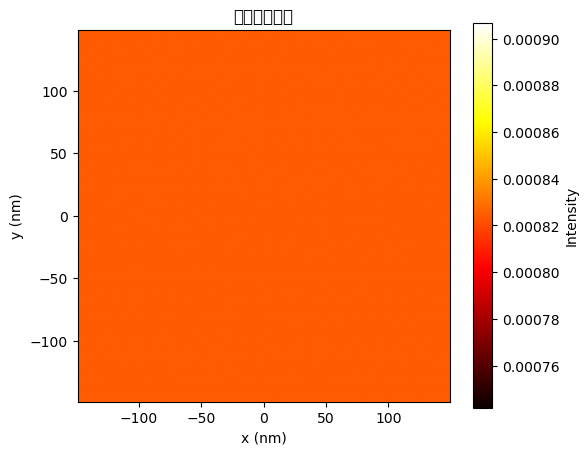

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# 物面参数
plane_size = 100  # 物面尺寸（nm）
size = 101  # 采样点数
dx = plane_size / size  # 采样间隔（nm）

# 创建物面坐标
x = np.linspace(-plane_size / 2, plane_size / 2, size)
y = np.linspace(-plane_size / 2, plane_size / 2, size)
X, Y = np.meshgrid(x, y)

# 定义矩形孔径（50 nm x 50 nm）
aperture_width = 50  # nm
aperture_height = 50  # nm

E_obj = np.zeros((size, size), dtype=complex)
E_obj[(np.abs(X) <= aperture_width / 2) & (np.abs(Y) <= aperture_height / 2)] = 1.0

# 第一步：扩充物面光场分布的矩阵
pad_width = 100  # 扩充宽度（根据需要调整）
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)

# 更新参数
N = E_obj_padded.shape[0]  # 新的矩阵大小
dx_padded = plane_size / size  # 采样间隔保持不变

# 第二步：进行傅立叶变换
# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx_padded)  # 单位：1/nm
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)

# 计算数值孔径 NA = λ * f
f_abs = np.sqrt(fx**2 + fy**2)
NA = lambda_wave * f_abs

# 第三步：计算光瞳函数
pupil = np.zeros_like(NA)
pupil[(NA >= NA_min) & (NA <= NA_max)] = 1.0

# 第四步：将光瞳函数作用在傅立叶变换后的矩阵上
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用光瞳函数
E_image_fft = E_obj_fft * pupil

# 第五步：进行傅立叶逆变换得到像面光场分布
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光场强度
I_image = np.abs(E_image)**2

# 可视化结果
plt.figure(figsize=(6, 5))
extent = [-N/2*dx_padded, N/2*dx_padded, -N/2*dx_padded, N/2*dx_padded]
plt.imshow(I_image, extent=extent, cmap='hot')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('像面光强分布')
plt.colorbar(label='Intensity')
plt.show()

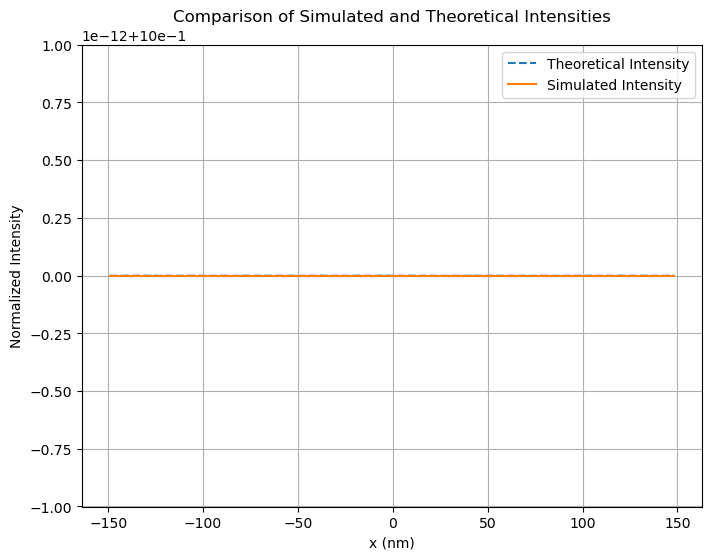

In [82]:
# 提取中心切片（沿 x 轴，y = 0）
center = N // 2
I_simulation = I_image[center, :]
x_image = (np.arange(-N/2, N/2) * dx_padded)

# 计算理论结果
# 频率坐标
fx_line = fx[center, :]
NA_line = NA[center, :]

# 光瞳函数
pupil_line = pupil[center, :]

# 理论上的 E_image_fft_line
E_theoretical_fft_line = aperture_width * np.sinc(aperture_width * fx_line)

# 应用光瞳函数
E_theoretical_fft_line *= pupil_line

# 逆傅立叶变换
E_theoretical_line = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(E_theoretical_fft_line)))
I_theoretical_line = np.abs(E_theoretical_line)**2

# 归一化
I_simulation_norm = I_simulation / np.max(I_simulation)
I_theoretical_norm = I_theoretical_line / np.max(I_theoretical_line)

# 绘制比较图
plt.figure(figsize=(8, 6))
plt.plot(x_image, I_theoretical_norm, label='Theoretical Intensity', linestyle='--')
plt.plot(x_image, I_simulation_norm, label='Simulated Intensity')

plt.xlabel('x (nm)')
plt.ylabel('Normalized Intensity')
plt.title('Comparison of Simulated and Theoretical Intensities')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
print(I_simulation_norm)
print(I_theoretical_norm)


[0.11082362 0.11081965 0.11081172 ... 0.11081172 0.11081965 0.11082362]
[0.11082911 0.11082911 0.11082514 ... 0.1108053  0.11081721 0.11082514]


In [83]:
print(I_simulation_norm)
print(I_theoretical_norm)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 

In [56]:
I_simulation_norm
I_theoretical_norm
x_image

array([-198.51485149, -197.52475248, -196.53465347, -195.54455446,
       -194.55445545, -193.56435644, -192.57425743, -191.58415842,
       -190.59405941, -189.6039604 , -188.61386139, -187.62376238,
       -186.63366337, -185.64356436, -184.65346535, -183.66336634,
       -182.67326733, -181.68316832, -180.69306931, -179.7029703 ,
       -178.71287129, -177.72277228, -176.73267327, -175.74257426,
       -174.75247525, -173.76237624, -172.77227723, -171.78217822,
       -170.79207921, -169.8019802 , -168.81188119, -167.82178218,
       -166.83168317, -165.84158416, -164.85148515, -163.86138614,
       -162.87128713, -161.88118812, -160.89108911, -159.9009901 ,
       -158.91089109, -157.92079208, -156.93069307, -155.94059406,
       -154.95049505, -153.96039604, -152.97029703, -151.98019802,
       -150.99009901, -150.        , -149.00990099, -148.01980198,
       -147.02970297, -146.03960396, -145.04950495, -144.05940594,
       -143.06930693, -142.07920792, -141.08910891, -140.09900

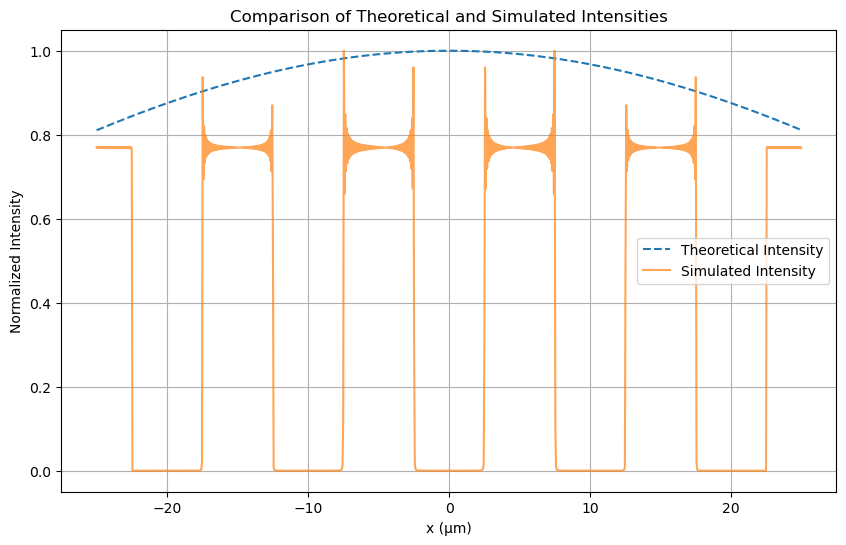

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# 全局参数
lambda_wave = 500  # 波长，单位：nm
plane_size = 50e3  # 物面尺寸，单位：nm（50 μm）
N = 1024  # 采样点数
dx = plane_size / N  # 采样间隔，单位：nm

# 物面坐标
x = np.linspace(-plane_size / 2, plane_size / 2 - dx, N)
X = x

# 单缝参数
a = 5e3  # 单缝宽度，单位：nm（5 μm）

def generate_slit_field(a, x):
    """
    生成物面单缝光场分布
    """
    E_obj = np.zeros_like(x)
    E_obj[np.abs(x) <= a / 2] = 1.0
    return E_obj

def calculate_theoretical_distribution(a, x, z, lambda_wave):
    """
    理论计算单缝在 z 处的衍射强度分布（夫琅禾费衍射）
    """
    # 计算角坐标
    theta = np.arctan(x / z)
    # 计算光强分布
    beta = (np.pi * a / lambda_wave) * np.sin(theta)
    I_theoretical = (a**2) * (np.sinc(beta / np.pi))**2
    return I_theoretical

def simulate_optical_system(E_obj, dx, lambda_wave, z):
    """
    使用傅里叶变换模拟光学系统（自由空间传输）
    """
    # 计算频率坐标
    fx = np.fft.fftfreq(N, d=dx)
    fx = np.fft.fftshift(fx)
    
    # 物面光场的傅里叶变换
    E_obj_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(E_obj)))
    
    # 传播因子（自由空间传输）
    H = np.exp(-1j * np.pi * lambda_wave * z * fx**2)
    
    # 像面光场
    E_image_fft = E_obj_fft * H
    E_image = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(E_image_fft)))
    
    return E_image

# 主程序
# 物面光场
E_obj = generate_slit_field(a, X)

# 传播距离
z = 1e6  # nm（1 mm）

# 理论计算
I_theoretical = calculate_theoretical_distribution(a, X, z, lambda_wave)

# 数值模拟
E_image = simulate_optical_system(E_obj, dx, lambda_wave, z)
I_simulation = np.abs(E_image)**2

# 归一化
I_theoretical_norm = I_theoretical / np.max(I_theoretical)
I_simulation_norm = I_simulation / np.max(I_simulation)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(X * 1e-3, I_theoretical_norm, label='Theoretical Intensity', linestyle='--')
plt.plot(X * 1e-3, I_simulation_norm, label='Simulated Intensity', alpha=0.7)
plt.xlabel('x (μm)')
plt.ylabel('Normalized Intensity')
plt.title('Comparison of Theoretical and Simulated Intensities')
plt.legend()
plt.grid(True)
plt.show()

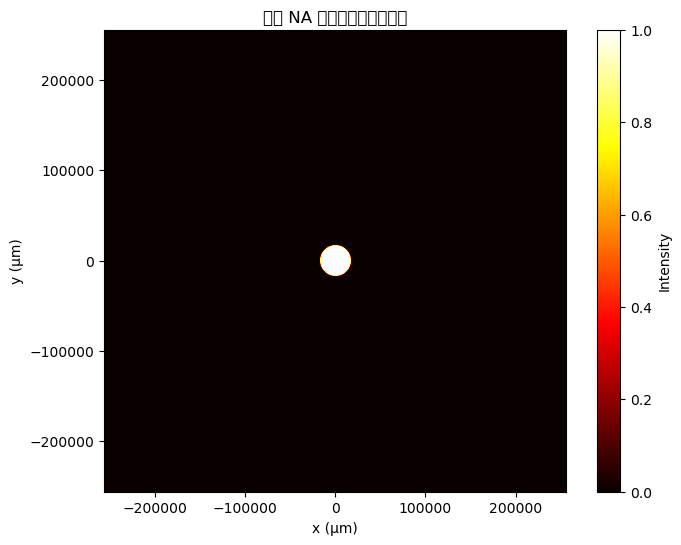

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def generate_circular_aperture(radius, grid_size, plane_size):
    """
    生成二维圆形孔径的光场分布。

    参数：
    - radius: 圆形孔径的半径（单位：米）。
    - grid_size: x 和 y 方向的采样点数。
    - plane_size: 平面尺寸（单位：米）。

    返回值：
    - aperture: 二维 numpy 数组，表示孔径函数。
    """
    x = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    y = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    aperture = np.zeros((grid_size, grid_size))
    aperture[R <= radius] = 1.0
    return aperture

# 模拟参数
lambda_wave = 500e-9      # 波长（500 nm）
plane_size = 1e-3         # 平面尺寸（1 mm x 1 mm）
grid_size = 1024          # 采样点数
pad_width = 1024          # 填充宽度，用于减小数值误差
radius = 0.1e-3           # 圆形孔径半径（100 μm）

# 数值孔径限制
NA_min = 0.0              # 最小数值孔径
NA_max = 0.5              # 最大数值孔径（可调整）

# 生成圆形孔径
E_obj = generate_circular_aperture(radius, grid_size, plane_size)

# 应用填充以减小数值误差
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)
N = E_obj_padded.shape[0]  # 更新后的采样点数

# 计算空间域采样间隔
dx = plane_size / grid_size  # 单位：米

# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx)
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)
f_abs = np.sqrt(fx**2 + fy**2)

# 计算对应的数值孔径 NA = λ * f
NA = f_abs * lambda_wave

# 定义光瞳函数，应用 NA 限制
pupil_function = np.zeros((N, N))
pupil_function[(NA >= NA_min) & (NA <= NA_max)] = 1.0

# 对物面光场进行傅立叶变换
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用光瞳函数（NA 限制）
E_image_fft = E_obj_fft * pupil_function

# 进行逆傅立叶变换得到像面光场
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光强分布
I_image = np.abs(E_image)**2

# 计算像面坐标
dfx = 1 / (N * dx)       # 频域采样间隔
x_image = np.linspace(-N/2, N/2-1, N) * (lambda_wave * dfx)
extent = [x_image.min()*1e6, x_image.max()*1e6, x_image.min()*1e6, x_image.max()*1e6]  # 单位转换为微米

# 绘制像面光强分布
plt.figure(figsize=(8, 6))
plt.imshow(I_image, extent=extent, cmap='hot')
plt.title('考虑 NA 限制的像面光强分布')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Intensity')
plt.show()

/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/2597312783.py:125: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/2597312783.py:125: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/2597312783.py:125: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/2597312783.py:125: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/2597312783.py:125: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/i

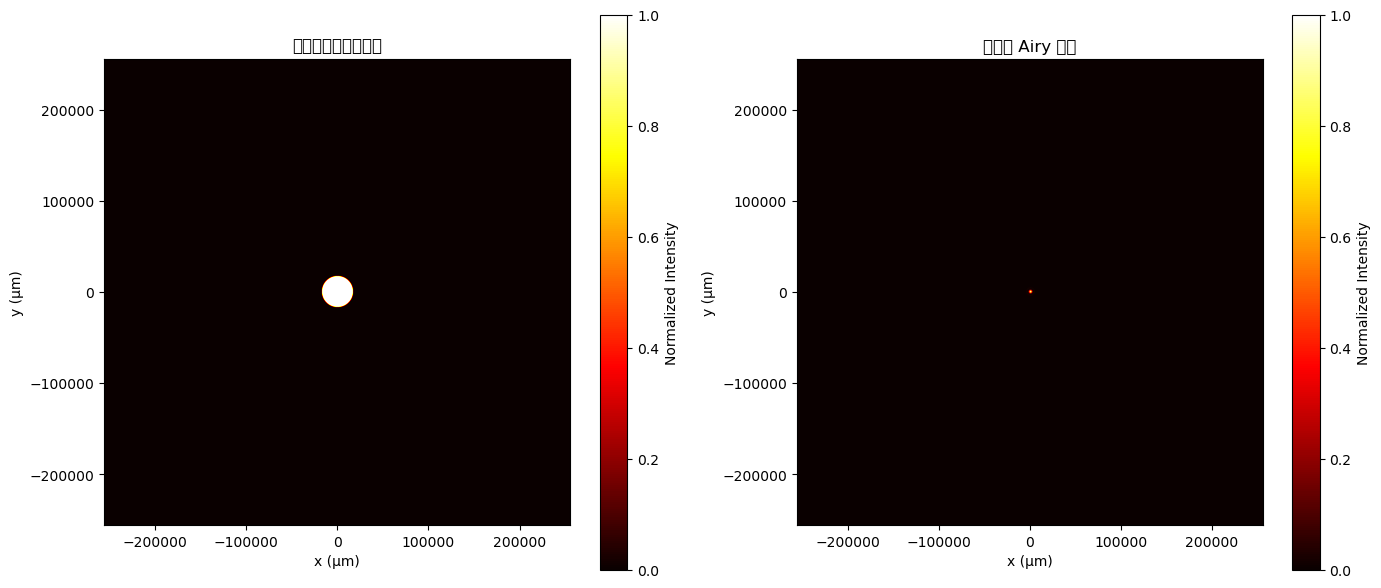

/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25130 (\N{CJK UNIFIED IDEOGRAPH-622A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/eroica/anaconda3/envs/swmm.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWar

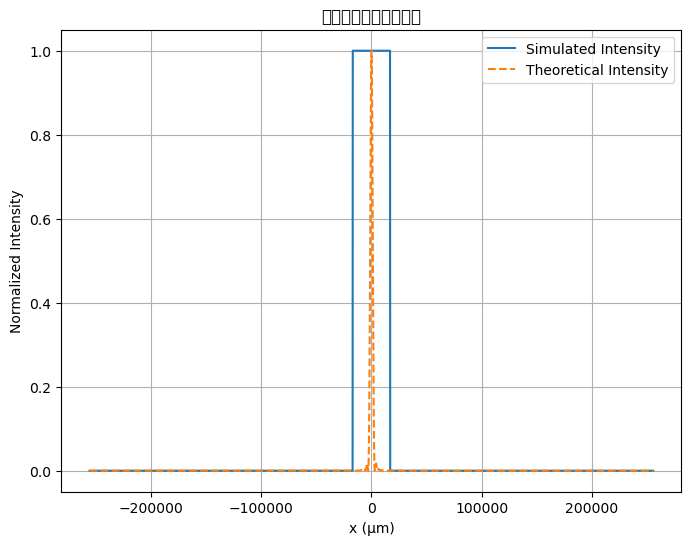

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # 导入第一类一阶贝塞尔函数

def generate_circular_aperture(radius, grid_size, plane_size):
    """
    生成二维圆形孔径的光场分布。

    参数：
    - radius: 圆形孔径的半径（单位：米）。
    - grid_size: x 和 y 方向的采样点数。
    - plane_size: 平面尺寸（单位：米）。

    返回值：
    - aperture: 二维 numpy 数组，表示孔径函数。
    """
    x = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    y = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    aperture = np.zeros((grid_size, grid_size))
    aperture[R <= radius] = 1.0
    return aperture, x, y

def calculate_theoretical_airydisk(radius, lambda_wave, X, Y, z=1.0):
    """
    计算圆形孔径的理论衍射图样（Airy 图样）。

    参数：
    - radius: 圆形孔径的半径（单位：米）。
    - lambda_wave: 波长（单位：米）。
    - X, Y: 像面坐标网格（单位：米）。
    - z: 传播距离（单位：米），默认为 1 米。

    返回值：
    - I_theoretical: 理论强度分布（归一化）。
    """
    k = 2 * np.pi / lambda_wave  # 波数
    R = np.sqrt(X**2 + Y**2)     # 像面上的径向坐标
    # 计算贝塞尔函数的参数
    beta = k * radius * R / z
    # 避免除以零
    beta[beta == 0] = 1e-20
    # 计算理论强度分布
    I_theoretical = (2 * j1(beta) / beta)**2
    # 归一化
    I_theoretical /= np.max(I_theoretical)
    return I_theoretical

# 模拟参数
lambda_wave = 500e-9      # 波长（500 nm）
plane_size = 1e-3         # 平面尺寸（1 mm x 1 mm）
grid_size = 1024          # 采样点数
pad_width = 1024*8          # 填充宽度，用于减小数值误差
radius = 0.1e-3           # 圆形孔径半径（100 μm）

# 数值孔径限制
NA_min = 0.0              # 最小数值孔径
NA_max = 0.6              # 最大数值孔径（可调整）

# 生成圆形孔径
E_obj, x, y = generate_circular_aperture(radius, grid_size, plane_size)

# 应用填充以减小数值误差
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)
N = E_obj_padded.shape[0]  # 更新后的采样点数

# 计算空间域采样间隔
dx = plane_size / grid_size  # 单位：米

# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx)
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)
f_abs = np.sqrt(fx**2 + fy**2)

# 计算对应的数值孔径 NA = λ * f
NA = f_abs * lambda_wave

# 定义光瞳函数，应用 NA 限制
pupil_function = np.zeros((N, N))
pupil_function[(NA >= NA_min) & (NA <= NA_max)] = 1.0

# 对物面光场进行傅立叶变换
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用光瞳函数（NA 限制）
E_image_fft = E_obj_fft * pupil_function

# 进行逆傅立叶变换得到像面光场
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光强分布
I_image = np.abs(E_image)**2
I_image /= np.max(I_image)  # 归一化

# 计算像面坐标
dfx = 1 / (N * dx)       # 频域采样间隔
x_image = np.linspace(-N/2, N/2-1, N) * (lambda_wave * dfx)
X_image, Y_image = np.meshgrid(x_image, x_image)

# 计算理论衍射强度分布
I_theoretical = calculate_theoretical_airydisk(radius, lambda_wave, X_image, Y_image, z=1.0)

# 绘制结果比较
plt.figure(figsize=(14, 6))

# 模拟结果
plt.subplot(1, 2, 1)
extent = [x_image.min()*1e6, x_image.max()*1e6, x_image.min()*1e6, x_image.max()*1e6]  # 单位转换为微米
plt.imshow(I_image, extent=extent, cmap='hot')
plt.title('模拟的像面光强分布')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

# 理论结果
plt.subplot(1, 2, 2)
plt.imshow(I_theoretical, extent=extent, cmap='hot')
plt.title('理论的 Airy 图样')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

plt.tight_layout()
plt.show()

# 提取中心截面进行比较
center_idx = N // 2
I_simulation_line = I_image[center_idx, :]
I_theoretical_line = I_theoretical[center_idx, :]
x_line = x_image * 1e6  # 单位转换为微米

# 绘制截面比较图
plt.figure(figsize=(8, 6))
plt.plot(x_line, I_simulation_line, label='Simulated Intensity')
plt.plot(x_line, I_theoretical_line, label='Theoretical Intensity', linestyle='--')
plt.title('中心截面光强分布比较')
plt.xlabel('x (μm)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/3204957157.py:111: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/3204957157.py:111: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/3204957157.py:111: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/3204957157.py:111: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/ipykernel_12594/3204957157.py:111: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/var/folders/d3/y48825nd7552km6p3p0wvt000000gn/T/i

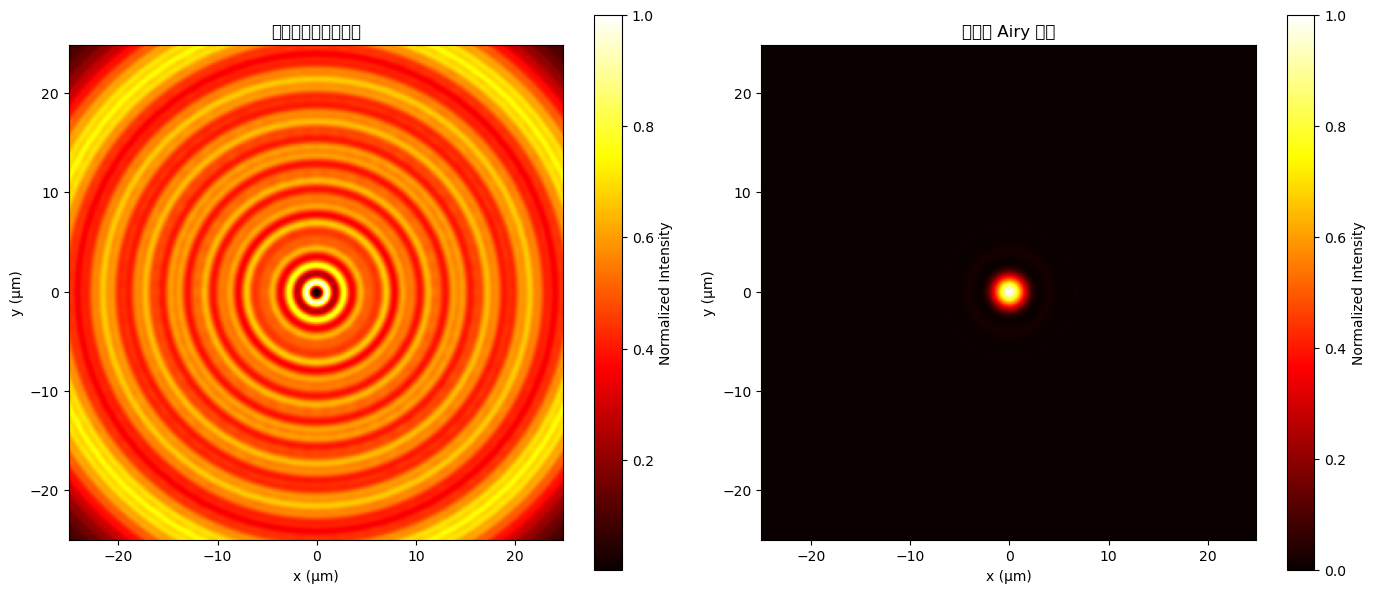

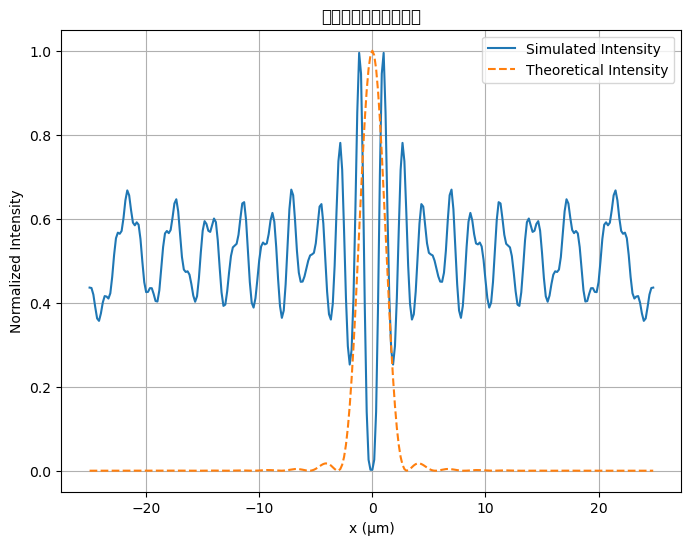

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # 导入第一类一阶贝塞尔函数

def generate_circular_aperture(radius, grid_size, plane_size):
    x = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    y = np.linspace(-plane_size / 2, plane_size / 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    aperture = np.zeros((grid_size, grid_size))
    aperture[R <= radius] = 1.0
    return aperture, x, y

def calculate_theoretical_airydisk(radius, lambda_wave, X, Y, z):
    k = 2 * np.pi / lambda_wave  # 波数（1/nm）
    R = np.sqrt(X**2 + Y**2)     # 像面上的径向坐标（nm）
    beta = k * radius * R / z
    I_theoretical = np.zeros_like(beta)
    # 避免除以零，在 beta = 0 处手动设置值
    I_theoretical[beta == 0] = 1.0
    # 其他位置计算
    mask = beta != 0
    I_theoretical[mask] = (2 * j1(beta[mask]) / beta[mask])**2
    # 归一化
    I_theoretical /= np.max(I_theoretical)
    return I_theoretical

# 模拟参数
lambda_wave = 500                # 波长（500 nm）
plane_size = 1000000             # 平面尺寸（1,000,000 nm，即 1 mm x 1 mm）
grid_size = 2048                 # 采样点数
pad_width = 2048                 # 填充宽度，用于减小数值误差
radius = 100000                  # 圆形孔径半径（100,000 nm，即 100 μm）
z = 1000000                      # 传播距离（1,000,000 nm，即 1 mm）

# 数值孔径限制
NA_min = 0.0                     # 最小数值孔径
NA_max = 1.0                     # 最大数值孔径（设置为 1.0，表示无 NA 限制）

# 生成圆形孔径
E_obj, x, y = generate_circular_aperture(radius, grid_size, plane_size)

# 应用填充以减小数值误差
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)
N = E_obj_padded.shape[0]        # 更新后的采样点数

# 计算空间域采样间隔
dx = plane_size / grid_size      # 采样间隔（单位：nm）

# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx)   # 单位：cycles/nm
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)
f_abs = np.sqrt(fx**2 + fy**2)

# 计算对应的数值孔径 NA = λ * f
NA = f_abs * lambda_wave

# 定义光瞳函数，应用 NA 限制
pupil_function = np.zeros((N, N))
pupil_function[(NA >= NA_min) & (NA <= NA_max)] = 1.0

# 计算自由空间传播的传递函数 H
H = np.exp(-1j * np.pi * lambda_wave * z * (fx**2 + fy**2))

# 对物面光场进行傅立叶变换
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用传递函数和光瞳函数
E_image_fft = E_obj_fft * H * pupil_function

# 进行逆傅立叶变换得到像面光场
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光强分布
I_image = np.abs(E_image)**2
I_image /= np.max(I_image)  # 归一化

# 计算像面采样间隔
dx_image = lambda_wave * z / (N * dx)  # 像面采样间隔（单位：nm）
x_image = np.linspace(-N/2, N/2-1, N) * dx_image
X_image, Y_image = np.meshgrid(x_image, x_image)

# 计算理论衍射强度分布
I_theoretical = calculate_theoretical_airydisk(radius, lambda_wave, X_image, Y_image, z)

# 设置绘图范围，显示更大的区域
plot_range = 10 * lambda_wave * z / radius  # 根据 Airy 图样的特征尺度确定绘图范围
idx_min = int(N/2 - plot_range / (2 * dx_image))
idx_max = int(N/2 + plot_range / (2 * dx_image))

plt.figure(figsize=(14, 6))

# 模拟结果
plt.subplot(1, 2, 1)
extent = [x_image[idx_min]*1e-3, x_image[idx_max-1]*1e-3, x_image[idx_min]*1e-3, x_image[idx_max-1]*1e-3]  # 单位转换为 μm
plt.imshow(I_image[idx_min:idx_max, idx_min:idx_max], extent=extent, cmap='hot', origin='lower')
plt.title('模拟的像面光强分布')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

# 理论结果
plt.subplot(1, 2, 2)
plt.imshow(I_theoretical[idx_min:idx_max, idx_min:idx_max], extent=extent, cmap='hot', origin='lower')
plt.title('理论的 Airy 图样')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

plt.tight_layout()
plt.show()

# 提取中心截面进行比较
center_idx = int((idx_max + idx_min) / 2)
I_simulation_line = I_image[center_idx, idx_min:idx_max]
I_theoretical_line = I_theoretical[center_idx, idx_min:idx_max]
x_line = x_image[idx_min:idx_max] * 1e-3  # 单位转换为 μm

# 绘制截面比较图
plt.figure(figsize=(8, 6))
plt.plot(x_line, I_simulation_line, label='Simulated Intensity')
plt.plot(x_line, I_theoretical_line, label='Theoretical Intensity', linestyle='--')
plt.title('中心截面光强分布比较')
plt.xlabel('x (μm)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# 更新采样点数，增加 pad_width 和物面光场采样密度
grid_size = 4096                # 物面光场采样点数
pad_width = 8192                # 填充宽度，增大频率分辨率
radius = 100000                 # 圆形孔径半径（100,000 nm，即 100 μm）
plane_size = 1000000            # 平面尺寸（1,000,000 nm，即 1 mm x 1 mm）
z = 1000000                     # 传播距离（1,000,000 nm，即 1 mm）

# 保持其他参数不变，重新进行计算
# 生成圆形孔径
E_obj, x, y = generate_circular_aperture(radius, grid_size, plane_size)

# 应用填充以减小数值误差
E_obj_padded = np.pad(E_obj, pad_width, mode='constant', constant_values=0)
N = E_obj_padded.shape[0]        # 更新后的采样点数

# 计算空间域采样间隔
dx = plane_size / grid_size      # 采样间隔（单位：nm）

# 计算频率坐标
freq = np.fft.fftfreq(N, d=dx)   # 单位：cycles/nm
freq = np.fft.fftshift(freq)
fx, fy = np.meshgrid(freq, freq)
f_abs = np.sqrt(fx**2 + fy**2)

# 计算对应的数值孔径 NA = λ * f
NA = f_abs * lambda_wave

# 定义光瞳函数，应用 NA 限制
pupil_function = np.zeros((N, N))
pupil_function[(NA >= NA_min) & (NA <= NA_max)] = 1.0

# 计算自由空间传播的传递函数 H
H = np.exp(-1j * np.pi * lambda_wave * z * (fx**2 + fy**2))

# 对物面光场进行傅立叶变换
E_obj_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_obj_padded)))

# 应用传递函数和光瞳函数
E_image_fft = E_obj_fft * H * pupil_function

# 进行逆傅立叶变换得到像面光场
E_image = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(E_image_fft)))

# 计算像面光强分布
I_image = np.abs(E_image)**2
I_image /= np.max(I_image)  # 归一化

# 剩余代码保持不变...

: 

In [ ]:

# 计算像面采样间隔
dx_image = lambda_wave * z / (N * dx)  # 像面采样间隔（单位：nm）
x_image = np.linspace(-N/2, N/2-1, N) * dx_image
X_image, Y_image = np.meshgrid(x_image, x_image)

# 计算理论衍射强度分布
I_theoretical = calculate_theoretical_airydisk(radius, lambda_wave, X_image, Y_image, z)

# 设置绘图范围，显示更大的区域
plot_range = 10 * lambda_wave * z / radius  # 根据 Airy 图样的特征尺度确定绘图范围
idx_min = int(N/2 - plot_range / (2 * dx_image))
idx_max = int(N/2 + plot_range / (2 * dx_image))

plt.figure(figsize=(14, 6))

# 模拟结果
plt.subplot(1, 2, 1)
extent = [x_image[idx_min]*1e-3, x_image[idx_max-1]*1e-3, x_image[idx_min]*1e-3, x_image[idx_max-1]*1e-3]  # 单位转换为 μm
plt.imshow(I_image[idx_min:idx_max, idx_min:idx_max], extent=extent, cmap='hot', origin='lower')
plt.title('模拟的像面光强分布')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

# 理论结果
plt.subplot(1, 2, 2)
plt.imshow(I_theoretical[idx_min:idx_max, idx_min:idx_max], extent=extent, cmap='hot', origin='lower')
plt.title('理论的 Airy 图样')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Normalized Intensity')

plt.tight_layout()
plt.show()

# 提取中心截面进行比较
center_idx = int((idx_max + idx_min) / 2)
I_simulation_line = I_image[center_idx, idx_min:idx_max]
I_theoretical_line = I_theoretical[center_idx, idx_min:idx_max]
x_line = x_image[idx_min:idx_max] * 1e-3  # 单位转换为 μm

# 绘制截面比较图
plt.figure(figsize=(8, 6))
plt.plot(x_line, I_simulation_line, label='Simulated Intensity')
plt.plot(x_line, I_theoretical_line, label='Theoretical Intensity', linestyle='--')
plt.title('中心截面光强分布比较')
plt.xlabel('x (μm)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid(True)
plt.show()